# Kaggle Playground Series 2024 – Loan Approval Prediction

## Objective
- Developed a predictive model to determine the likelihood of an applicant’s loan approval, honing skills in classification modeling.

## Dataset
- Engaged with a synthetic, tabular dataset modeled on real-world data to simulate a loan approval scenario.

## Techniques

### Step1: Data Preprocessing
- Conducted data loading, merging, checking for duplicates and handling NaNs. 

### Step2: Exploratory Data Analysis (EDA)
- Conducted visualizations and statistical analysis to understand feature distributions and relationships.

### Step3: Feature Engineering
- Created new variables, transformed features, and optimized data representation for improved model performance.

### Step4: Model Selection and Training 
- Experimented with classification algorithms, including:
  - ExtraTrees
  - XGBoost
  - Random Forest
  - Gradient Boosting
  - CatBoost
  - LightGBM
- Identified the best-performing model based on stratified cross validation score.
- Hyperparameter Tunning

### Step5: Model Evaluation 
- Optimized for the following metrics:
  - F1-score
  - Precision
  - Recall
- Confusion matrix for the best performing model  
- ROC curve to see how well the classifier seperates the classes.  
- Assessed the model's predictive capabilities accross different probability thresholds.
- Learning Curves to check overfitting

### Step6: Blending and Stacking models
- Blended the best performing classifiers using weighted voting classifiers
-  stacked best performing classifiers with LogisticRegression as final estimator 

### Step7: # Prediction on Kaggle Test Data
- Performed the preprocessing and feature engineering steps on test data
- Generated predicted probalities on test set using catboost classifier 

## Achievements
- Achieved a final AUC score of 0.96 on kaggle's test set, demonstrating a deep understanding of the machine learning workflow, from data preprocessing to model deployment.

## Outcome
- Enhanced skills in data handling, model tuning, and iterative improvement of classification models, further solidifying expertise in applied machine learning.


In [360]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import mutual_info_classif
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# Step1: Data Preprocessing

## Loading the Original Data
###  https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction


In [361]:
original = pd.read_csv('/Users/shemontod/Desktop/practice/LoanApproval/credit_risk_dataset.csv')
original

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Checking Null values and dropping them

In [362]:
original.isnull().any()

person_age                    False
person_income                 False
person_home_ownership         False
person_emp_length              True
loan_intent                   False
loan_grade                    False
loan_amnt                     False
loan_int_rate                  True
loan_status                   False
loan_percent_income           False
cb_person_default_on_file     False
cb_person_cred_hist_length    False
dtype: bool

In [367]:
original_df = original.dropna()
original_df.shape

(28638, 12)

### Checking for duplicates

In [363]:
duplicate_rows = original_df[original_df.duplicated()]
duplicate_rows

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length


In [364]:
original_df = original_df.drop_duplicates()
original_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [365]:
original_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28501.000000,2.850100e+04,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000
mean,27.738676,6.665441e+04,4.790148,9658.533034,11.045385,0.217115,0.169517,5.800498
std,6.316166,6.237603e+04,4.157462,6329.604672,3.230748,0.412289,0.106410,4.042153
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.950000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### There are some abnormal values in 'person_age' and 'person_emp_length' columns. The max 'person_age' and 'person_emp_length' is 144 and 123 which aren't realistic. So  filtering has been performed based on this two columns

In [366]:
original_df = original_df[(original_df['person_age'] <= 90) & (original_df['person_emp_length']!=123)]
original_df.shape

(28495, 12)

In [332]:
original_df.loan_status.value_counts()

loan_status
0    22308
1     6187
Name: count, dtype: int64

## Loading Synthetic data for the competition

In [333]:
train_df = pd.read_csv('/Users/shemontod/Desktop/practice/LoanApproval/train.csv')
test_df = pd.read_csv('/Users/shemontod/Desktop/practice/LoanApproval/test.csv')
print(train_df.shape, test_df.shape)
train_df

(58645, 13) (39098, 12)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [334]:
train_df = train_df.drop(columns=['id'])

In [335]:
train_df = train_df[(train_df['person_age']!=123) & (train_df['person_emp_length']!=123)]
train_df.shape

(58642, 12)

In [336]:
duplicate_rows_syn = train_df[train_df.duplicated()]
duplicate_rows_syn

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [354]:
# no null values present

train_df.isnull().any()

person_age                    False
person_income                 False
person_home_ownership         False
person_emp_length             False
loan_intent                   False
loan_grade                    False
loan_amnt                     False
loan_int_rate                 False
loan_percent_income           False
cb_person_default_on_file     False
cb_person_cred_hist_length    False
loan_status                   False
dtype: bool

In [338]:
train_df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [353]:
# checking descriptive statistics for train data

train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58642.000000,5.864200e+04,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000
mean,27.549333,6.404453e+04,4.696941,9217.146448,10.677770,0.159235,5.813649,0.142372
std,6.020420,3.792822e+04,3.899139,5563.380070,3.034695,0.091690,4.029261,0.349435
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,84.000000,1.900000e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [352]:
# checking descriptive statistics for test data

test_df.describe()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,1.663282,4.687068,2.538826,1.061742,9251.466188,10.661216,0.159573,0.150161,5.830707
std,11286.764749,6.032761,3.795583e+04,1.454022,3.868395,1.713407,1.039602,5576.254680,3.020220,0.091633,0.357234,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,700.000000,5.420000,0.000000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,7.880000,0.090000,0.000000,3.000000
50%,78193.500000,26.000000,5.800000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,10.750000,0.140000,0.000000,4.000000
75%,87967.750000,30.000000,7.588500e+04,3.000000,7.000000,4.000000,2.000000,12000.000000,12.990000,0.210000,0.000000,8.000000
max,97742.000000,94.000000,1.900000e+06,3.000000,42.000000,5.000000,6.000000,35000.000000,22.110000,0.730000,1.000000,30.000000


### Merge original and synthetic data

In [341]:

merged_df = pd.concat([train_df, original_df], ignore_index=True)
merged_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
87132,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
87133,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
87134,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
87135,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [342]:
merged_df.isnull().any()

person_age                    False
person_income                 False
person_home_ownership         False
person_emp_length             False
loan_intent                   False
loan_grade                    False
loan_amnt                     False
loan_int_rate                 False
loan_percent_income           False
cb_person_default_on_file     False
cb_person_cred_hist_length    False
loan_status                   False
dtype: bool

### Looking into the categorical variables and unique categories in them

In [344]:
categorical_features = merged_df.select_dtypes(include=['object', 'category']).columns

for feature in categorical_features:
    unique_values = merged_df[feature].unique()
    print(f"{len(unique_values)} unique values in {feature}: {unique_values}")

4 unique values in person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
6 unique values in loan_intent: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
7 unique values in loan_grade: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
2 unique values in cb_person_default_on_file: ['N' 'Y']


### As we can see above person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file are categorical features.

### Encoding the categorical features using Label Encoder

In [345]:
le = LabelEncoder()

for feature in categorical_features:
    merged_df[feature] = le.fit_transform(merged_df[feature])
merged_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
87132,57,53000,0,1.0,4,2,5800,13.16,0.11,0,30,0
87133,54,120000,0,4.0,4,0,17625,7.49,0.15,0,19,0
87134,65,76000,3,3.0,2,1,35000,10.99,0.46,0,28,1
87135,56,150000,0,5.0,4,1,15000,11.48,0.10,0,26,0


In [346]:
# encoding test data as well

for feature in categorical_features:
    test_df[feature] = le.fit_transform(test_df[feature])


In [347]:
merged_df.loan_status.value_counts()

loan_status
0    72601
1    14536
Name: count, dtype: int64

In [348]:
test_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,3,3.0,2,5,25000,15.76,0.36,0,2
1,58646,26,96000,0,6.0,4,2,10000,12.68,0.10,1,4
2,58647,26,30000,3,5.0,5,4,4000,17.19,0.13,1,2
3,58648,33,50000,3,4.0,0,0,7000,8.90,0.14,0,7
4,58649,26,102000,0,8.0,2,3,15000,16.32,0.15,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,0,2.0,0,1,3000,10.37,0.10,0,4
39094,97739,22,48000,0,6.0,1,0,7000,6.03,0.15,0,3
39095,97740,51,60000,0,0.0,4,0,15000,7.51,0.25,0,25
39096,97741,22,36000,0,4.0,4,3,14000,15.62,0.39,1,4


# Step2: Exploratory Data Analysis (EDA)

### Analyzing the distribution of the Categorical & Numerical features to get a deatiled understanding

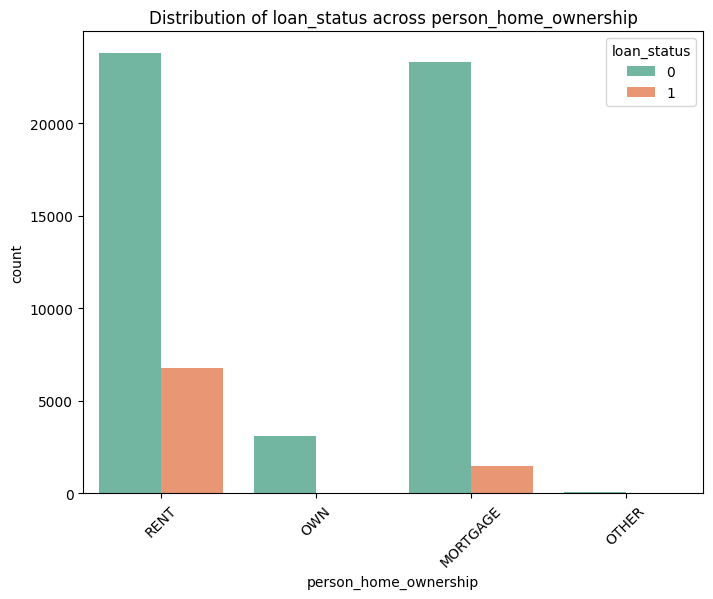

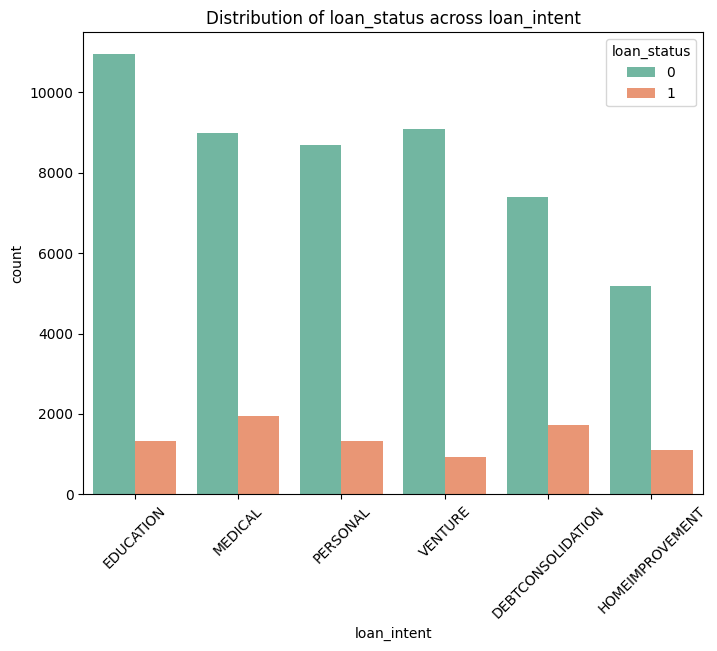

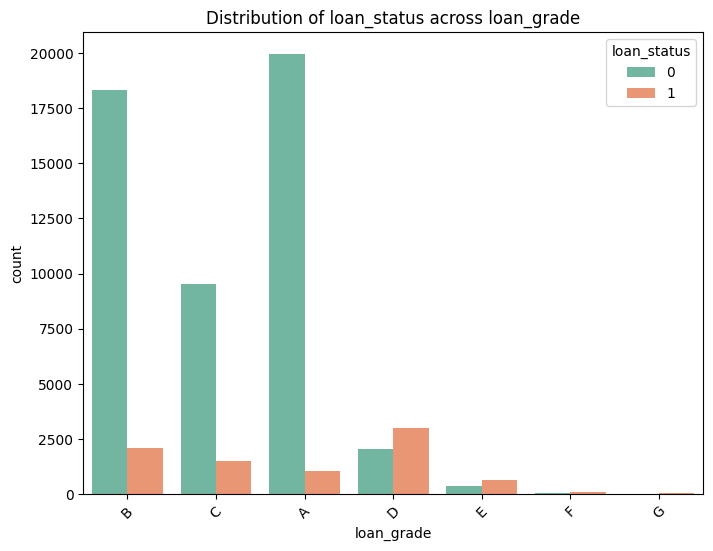

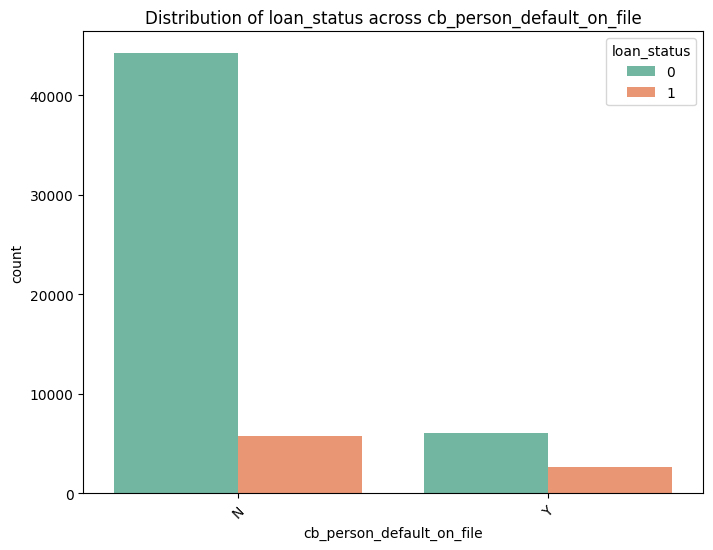

In [368]:
target_feature = 'loan_status'  
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=train_df, x=feature, hue=target_feature, palette='Set2')
    plt.title(f"Distribution of {target_feature} across {feature}")
    plt.xticks(rotation=45) 
    plt.show()

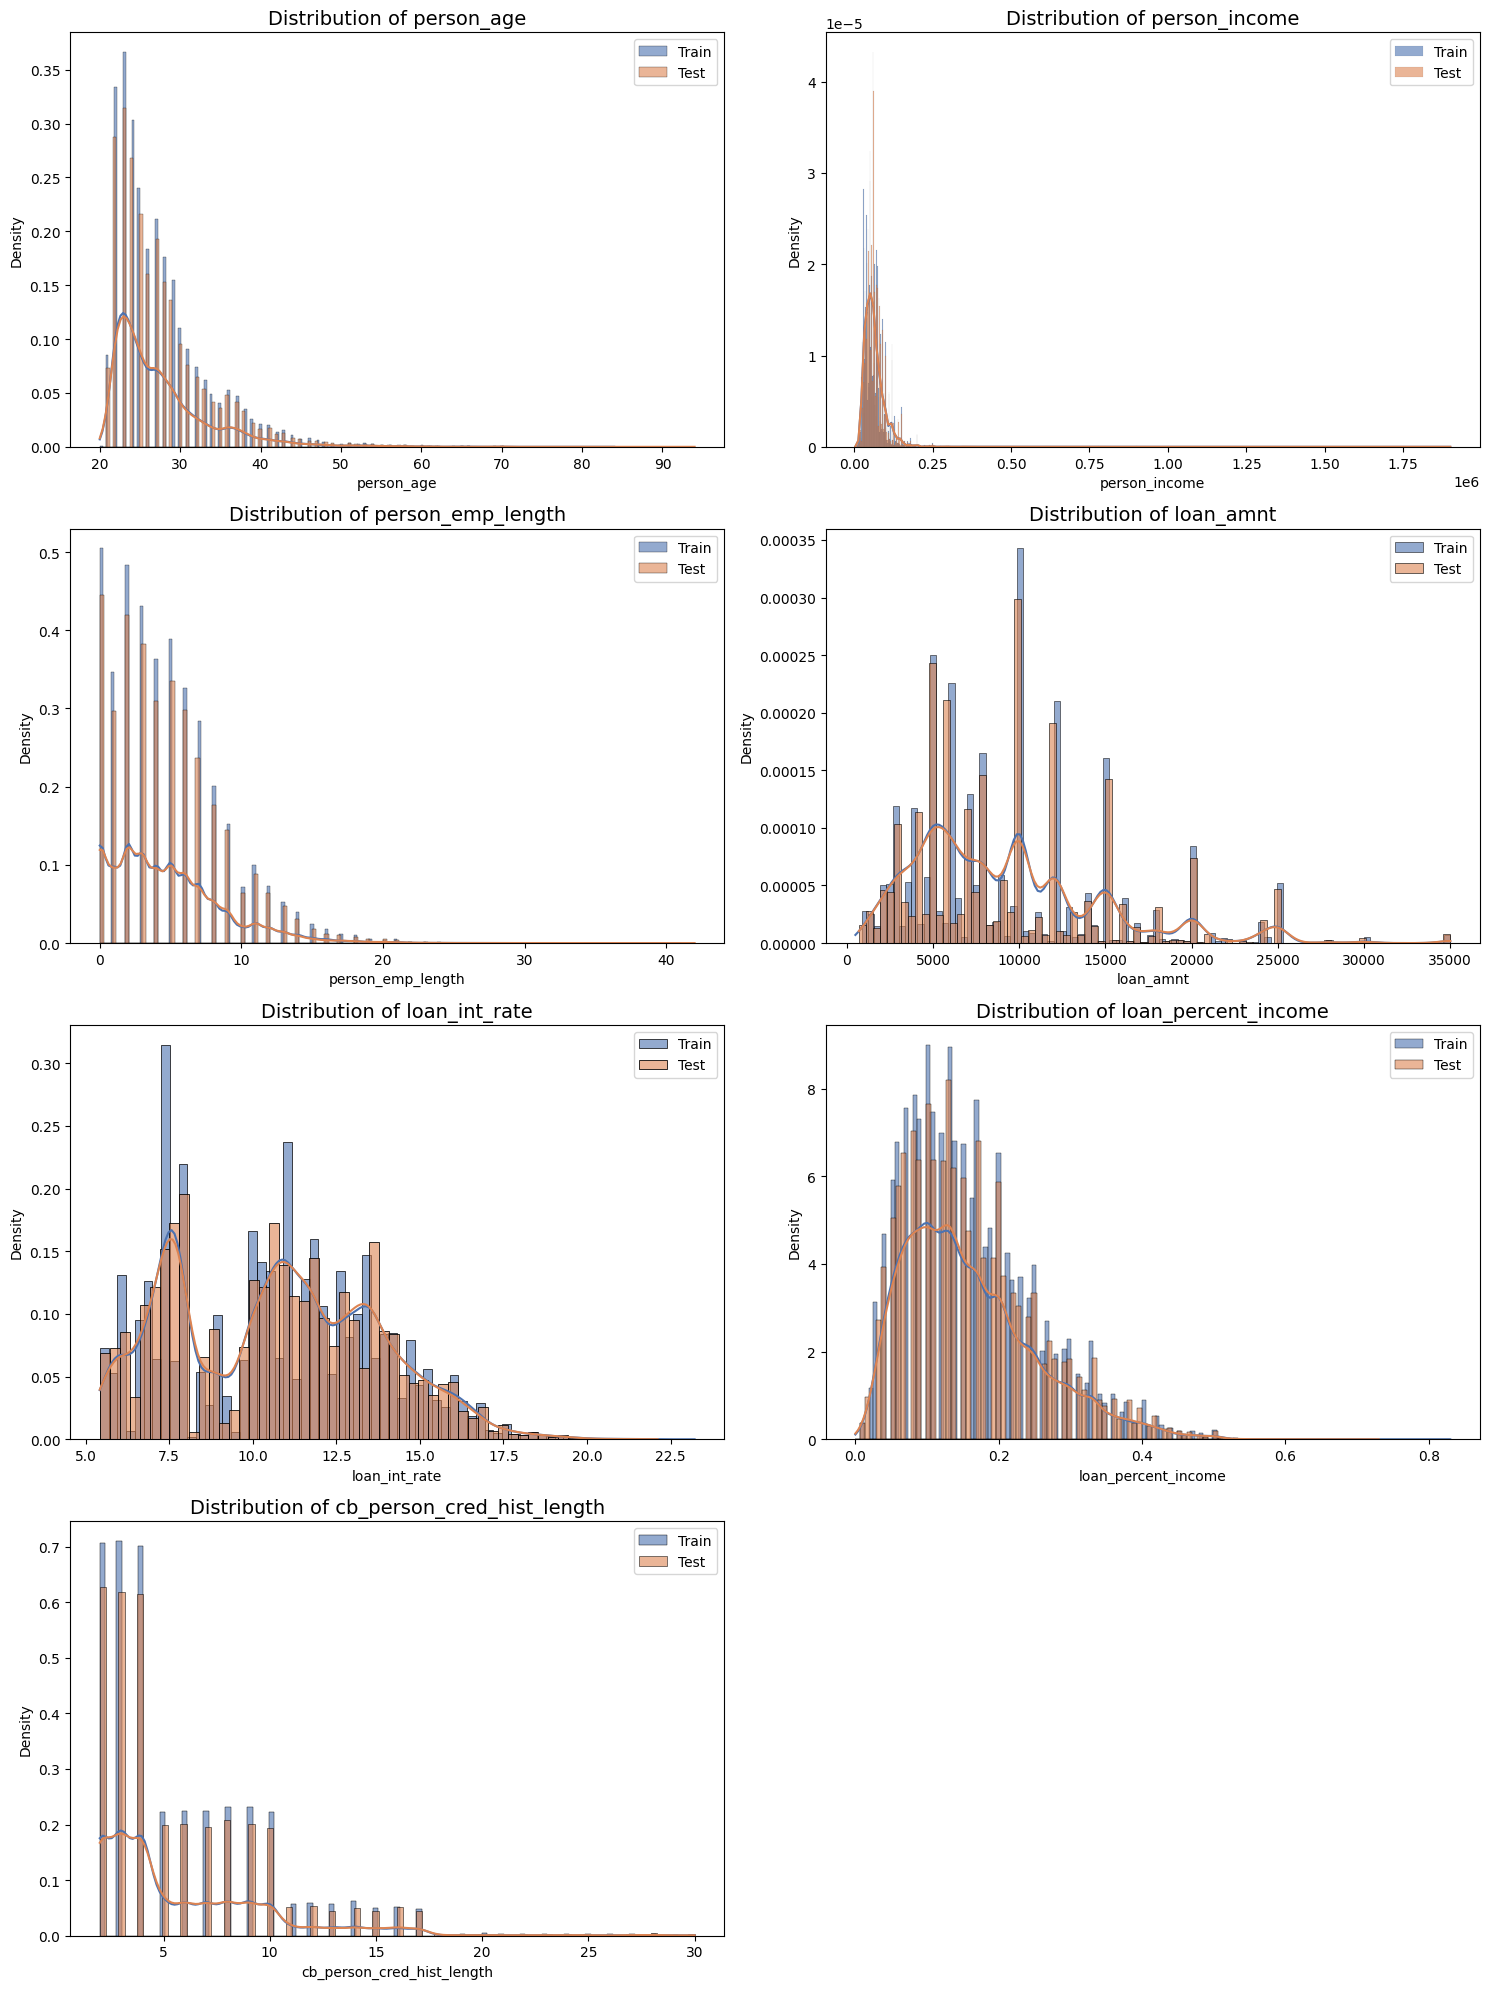

In [370]:
excluded_features = ['id', 'loan_status']
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [col for col in numerical_features if col not in excluded_features]

n_features = len(numerical_features)
n_cols = 2  
n_rows = (n_features + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()
palette = sns.color_palette("deep")

for i, feature in enumerate(numerical_features):
    sns.histplot(train_df[feature], kde=True, ax=axes[i], color=palette[0], label='Train', stat='density', alpha=0.6)
    sns.histplot(test_df[feature], kde=True, ax=axes[i], color=palette[1], label='Test', stat='density', alpha=0.6)
    
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].legend(loc='upper right', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### It seems like the trin and test set distribution are almost alike which shows no data drifts.

# Step3: Feature Engineering

In [349]:
df = merged_df.copy()
df.shape

(87137, 12)

In [289]:

# 1. Loan-to-Income Ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

# 2. Employment Stability Features
# Bin employment length into categories
bins = [0, 1, 5, 10, float('inf')]
labels = ['0-1 years', '2-5 years', '6-10 years', '11+ years']
df['emp_length_bin'] = pd.cut(df['person_emp_length'], bins=bins, labels=labels, right=False)

# Income Growth Potential: If high income but short employment length indicates growth potential
df['income_growth_potential'] = (df['person_income'] > df['person_income'].median()) & (df['person_emp_length'] < 2)

# 3. Credit Age to Employment Length Ratio
df['credit_age_to_emp_length_ratio'] = df['cb_person_cred_hist_length'] / (df['person_emp_length'] + 1)

#4. Loan Percent Income High: Binary feature indicating if loan percentage of income exceeds 30%
df['loan_percent_income_high'] = df['loan_percent_income'] > 0.30

#5. Loan Amount Bins: Grouping loans into 'small', 'medium', and 'large' bins
loan_bins = [0, 5000, 10000, float('inf')]
loan_labels = ['small', 'medium', 'large']
df['loan_amnt_bin'] = pd.cut(df['loan_amnt'], bins=loan_bins, labels=loan_labels, right=False)


df[['loan_to_income_ratio', 'emp_length_bin', 'income_growth_potential', 'credit_age_to_emp_length_ratio', 'loan_percent_income_high', 'loan_amnt_bin']].head()


,loan_to_income_ratio,emp_length_bin,income_growth_potential,credit_age_to_emp_length_ratio,loan_percent_income_high,loan_amnt_bin
0,0.171429,0-1 years,False,14.000000,False,medium
1,0.071429,6-10 years,False,0.285714,False,small
2,0.208333,6-10 years,False,1.111111,False,medium
3,0.171429,11+ years,False,0.333333,False,large
4,0.100000,2-5 years,False,1.000000,False,medium


### Mapping the newly created categorical features to numeric features 

In [290]:
df['income_growth_potential'] = df['income_growth_potential'].map({True: 1, False: 0}) 
df['loan_amnt_bin'] = df['loan_amnt_bin'].map({'small': 0, 'medium': 1, 'large':2}).astype(int) 
df['loan_percent_income_high'] = df['loan_percent_income_high'].map({True: 1, False: 0}) 
df['emp_length_bin'] = df['emp_length_bin'].map({'0-1 years': 0, '2-5 years': 1, '6-10 years': 2, '11+ years': 3}).astype(int)


In [291]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_to_income_ratio,emp_length_bin,income_growth_potential,credit_age_to_emp_length_ratio,loan_percent_income_high,loan_amnt_bin
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0,0.171429,0,0,14.000000,0,1
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0,0.071429,2,0,0.285714,0,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0,0.208333,2,0,1.111111,0,1
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0,0.171429,3,0,0.333333,0,2
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0,0.100000,1,0,1.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87132,57,53000,0,1.0,4,2,5800,13.16,0.11,0,30,0,0.109434,1,0,15.000000,0,1
87133,54,120000,0,4.0,4,0,17625,7.49,0.15,0,19,0,0.146875,1,0,3.800000,0,2
87134,65,76000,3,3.0,2,1,35000,10.99,0.46,0,28,1,0.460526,1,0,7.000000,1,2
87135,56,150000,0,5.0,4,1,15000,11.48,0.10,0,26,0,0.100000,2,0,4.333333,0,2


### The dataset is highly imbalanced. Using Synthetic Minority Oversampling Techinique (SMOTE) to balance the dataset so that the classification accuracy is enhanced.

In [294]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [295]:
print("After Over Sampling, Total Samples are:", len(y_train_resampled))
print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_train_resampled))

After Over Sampling, Total Samples are: 101540
Original dataset shape: Counter({0: 50770, 1: 10225})
Resampled dataset shape: Counter({0: 50770, 1: 50770})


### Scaling the training and test data seperately using Standard Scaler.

In [296]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

X_test_scaled = scaler.transform(X_test)


## Looking into the correlational matrix to see correlation among the features

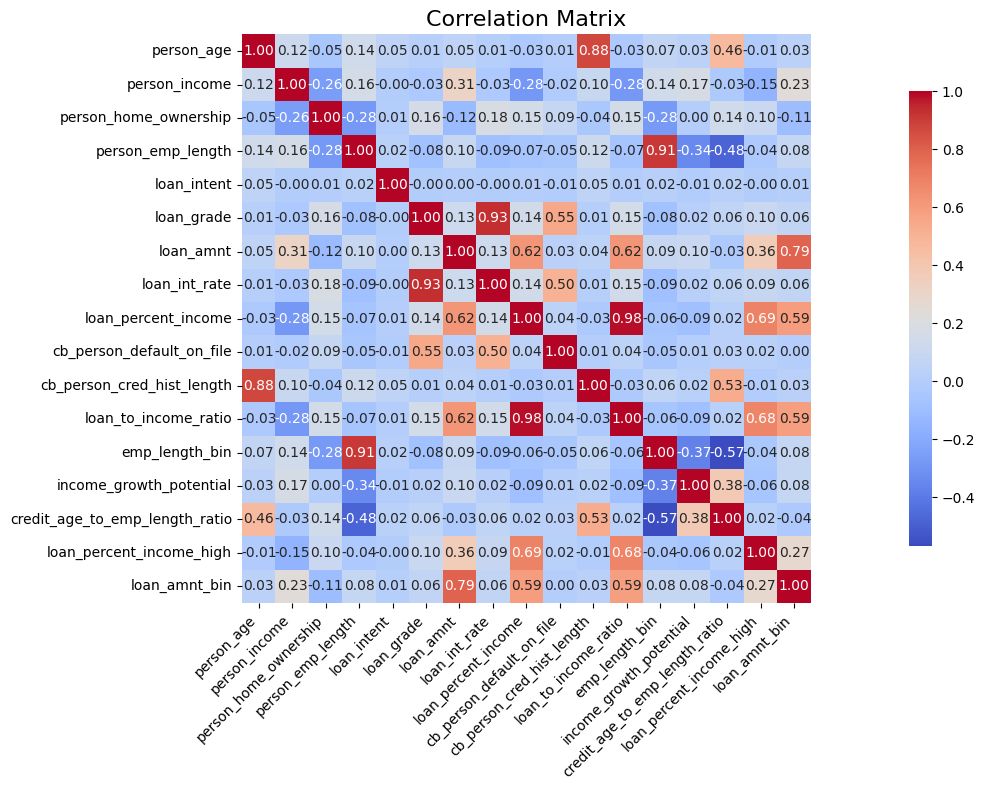

In [297]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(20, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### person_age and cb_person_cred_hist_length is highly correlated which is understandable.
### loan_int_rate and loan_grade is also highly correlated. To decide whether I should be dropping any one of them I will be looking in to the 
### mutual information of each feature with respect to the target feature.

In [298]:
mutual_info = mutual_info_classif(X_train_resampled_scaled, y_train_resampled, discrete_features='auto')
mutual_info_df = pd.DataFrame(mutual_info, index=X_train.columns, columns=['Mutual Information']).sort_values(by='Mutual Information', ascending=False)
mutual_info_df

,Mutual Information
loan_int_rate,0.439143
credit_age_to_emp_length_ratio,0.376319
person_emp_length,0.328592
loan_to_income_ratio,0.245122
person_income,0.236878
loan_percent_income,0.216472
loan_amnt,0.109689
loan_percent_income_high,0.109444
loan_grade,0.084746
person_home_ownership,0.072281


### From this I came to a conclusion of not dropping any one of loan_int_rate and loan_grade as they have some sort of dependency
### with the target 

# Step4: Model Selection and Training 
## Performed stratified cross validation with 6 different classifiers to selct the classifier with highest Cross Validation score

In [299]:
X_train_resampled.isna().any()

person_age                        False
person_income                     False
person_home_ownership             False
person_emp_length                 False
loan_intent                       False
loan_grade                        False
loan_amnt                         False
loan_int_rate                     False
loan_percent_income               False
cb_person_default_on_file         False
cb_person_cred_hist_length        False
loan_to_income_ratio              False
emp_length_bin                    False
income_growth_potential           False
credit_age_to_emp_length_ratio    False
loan_percent_income_high          False
loan_amnt_bin                     False
dtype: bool

In [231]:
warnings.filterwarnings('ignore')

classifiers = {
    "ExtraTrees": ExtraTreesClassifier(random_state=30),
    "RandomForest": RandomForestClassifier(random_state=30),
    "GradientBoosting": GradientBoostingClassifier(random_state=30),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=30),
    "LightGBM": LGBMClassifier(random_state=30),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=30)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_scores = {}

for name, model in classifiers.items():
    print(f"Evaluating {name}...")
    auc_scores = cross_val_score(
        model, X_train_resampled_scaled, y_train_resampled, cv=skf, scoring=make_scorer(roc_auc_score)
    )
    model_scores[name] = auc_scores
    print(f"{name} AUC Scores: {auc_scores}")
    print(f"Average AUC: {auc_scores.mean():.2f}\n")

best_model_name = max(model_scores, key=lambda x: model_scores[x].mean())
print(f"Best Model: {best_model_name} with Average AUC: {model_scores[best_model_name].mean():.2f}")

Evaluating ExtraTrees...
ExtraTrees AUC Scores: [0.92643293 0.9278117  0.92470947 0.92574355 0.92613748]
Average AUC: 0.93

Evaluating RandomForest...
RandomForest AUC Scores: [0.93928501 0.94120544 0.93761079 0.93972819 0.93884184]
Average AUC: 0.94

Evaluating GradientBoosting...
GradientBoosting AUC Scores: [0.90220603 0.90279693 0.90629309 0.9089029  0.90506204]
Average AUC: 0.91

Evaluating XGBoost...
XGBoost AUC Scores: [0.95632263 0.95184164 0.95129998 0.95405751 0.95326965]
Average AUC: 0.95

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 40616, number of negative: 40616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 81232, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg

### Catboost is the best performing model with a cross validation score of 0.96

## Hyperparameter Tuning with Optuna

In [ ]:
import optuna


warnings.filterwarnings('ignore')

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0,
    }

    model = CatBoostClassifier(**param)

    model.fit(X_train_resampled_scaled, y_train_resampled, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50)

    preds = model.predict_proba(X_test_scaled)[:, 1]
    score = roc_auc_score(y_test, preds)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

print("Best hyperparameters: ", study.best_params)
print("Best AUC score: ", study.best_value)


## Training 

### Catboost

In [300]:

catboost = CatBoostClassifier(random_state=30)
catboost.fit(X_train_resampled_scaled, y_train_resampled)

Learning rate set to 0.074091
0:	learn: 0.6368510	total: 8.48ms	remaining: 8.47s
1:	learn: 0.5826107	total: 15.8ms	remaining: 7.88s
2:	learn: 0.5382323	total: 23.4ms	remaining: 7.78s
3:	learn: 0.5061588	total: 30ms	remaining: 7.47s
4:	learn: 0.4818828	total: 36.5ms	remaining: 7.26s
5:	learn: 0.4595454	total: 44ms	remaining: 7.28s
6:	learn: 0.4374928	total: 50.7ms	remaining: 7.2s
7:	learn: 0.4247823	total: 58ms	remaining: 7.19s
8:	learn: 0.4122430	total: 64.8ms	remaining: 7.14s
9:	learn: 0.3998455	total: 72.5ms	remaining: 7.18s
10:	learn: 0.3874955	total: 79.4ms	remaining: 7.14s
11:	learn: 0.3741809	total: 86.6ms	remaining: 7.13s
12:	learn: 0.3665008	total: 93.1ms	remaining: 7.07s
13:	learn: 0.3611487	total: 100ms	remaining: 7.06s
14:	learn: 0.3537634	total: 107ms	remaining: 7.04s
15:	learn: 0.3455875	total: 115ms	remaining: 7.08s
16:	learn: 0.3340311	total: 122ms	remaining: 7.05s
17:	learn: 0.3280926	total: 130ms	remaining: 7.07s
18:	learn: 0.3210441	total: 137ms	remaining: 7.06s
19:	l

### LGBM

In [305]:
lightgbm = LGBMClassifier(random_state=30)

lightgbm.fit(X_train_resampled_scaled, y_train_resampled)

[LightGBM] [Info] Number of positive: 50770, number of negative: 50770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 101540, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=30)

## XGB

In [308]:
xgb = XGBClassifier(eval_metric='logloss', random_state=30)
xgb.fit(X_train_resampled_scaled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=30, ...)

# Step5: Model Evaluation 

In [303]:
predictions_cat = catboost.predict(X_test_scaled)
f1 = f1_score(y_test, predictions_cat)
probabilities_cat = catboost.predict_proba(X_test_scaled)[:, 1]  
auc = roc_auc_score(y_test, probabilities_cat)
print(f'AUC: {auc:.2f}')
print(f'F1 Score: {f1:.2f}') 


AUC: 0.95
F1 Score: 0.82


In [304]:
report_cat = classification_report(y_test, predictions_cat)
print(report_cat)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21831
           1       0.92      0.75      0.82      4311

    accuracy                           0.95     26142
   macro avg       0.93      0.87      0.90     26142
weighted avg       0.95      0.95      0.94     26142



In [306]:
predictions_lgbm = lightgbm.predict(X_test_scaled)
f1 = f1_score(y_test, predictions_lgbm)
probabilities_lgbm = lightgbm.predict_proba(X_test_scaled)[:, 1]  
auc = roc_auc_score(y_test, probabilities_lgbm)
print(f'AUC: {auc:.2f}')
print(f'F1 Score: {f1:.2f}') 


AUC: 0.95
F1 Score: 0.81


In [307]:
report_lgbm = classification_report(y_test, predictions_lgbm)
print(report_lgbm)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     21831
           1       0.89      0.74      0.81      4311

    accuracy                           0.94     26142
   macro avg       0.92      0.86      0.89     26142
weighted avg       0.94      0.94      0.94     26142



In [309]:
predictions_xgb = xgb.predict(X_test_scaled)
f1 = f1_score(y_test, predictions_xgb)
probabilities_xgb = xgb.predict_proba(X_test_scaled)[:, 1]  
auc = roc_auc_score(y_test, probabilities_xgb)
print(f'AUC: {auc:.2f}')
print(f'F1 Score: {f1:.2f}') 


AUC: 0.95
F1 Score: 0.82


In [310]:
report = classification_report(y_test, predictions_xgb)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     21831
           1       0.90      0.75      0.82      4311

    accuracy                           0.95     26142
   macro avg       0.93      0.87      0.89     26142
weighted avg       0.94      0.95      0.94     26142



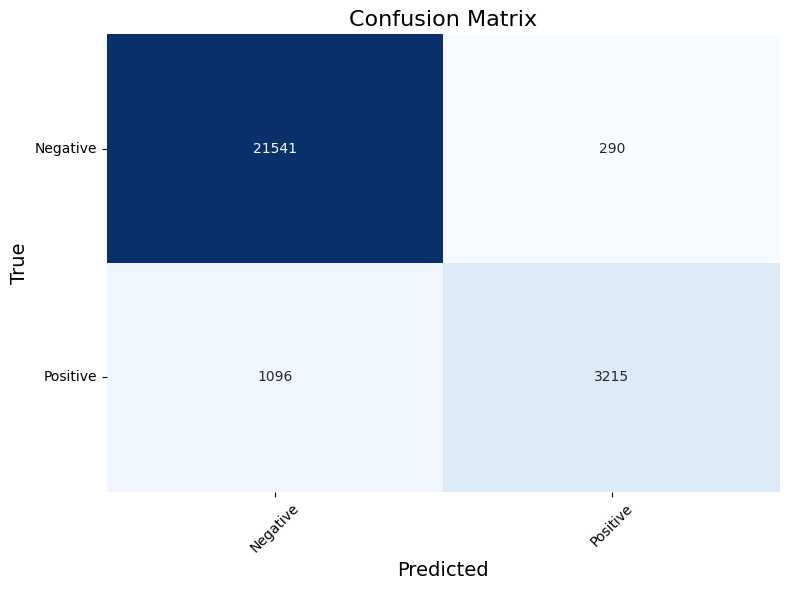

In [59]:
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## ROC Curve of Catboost

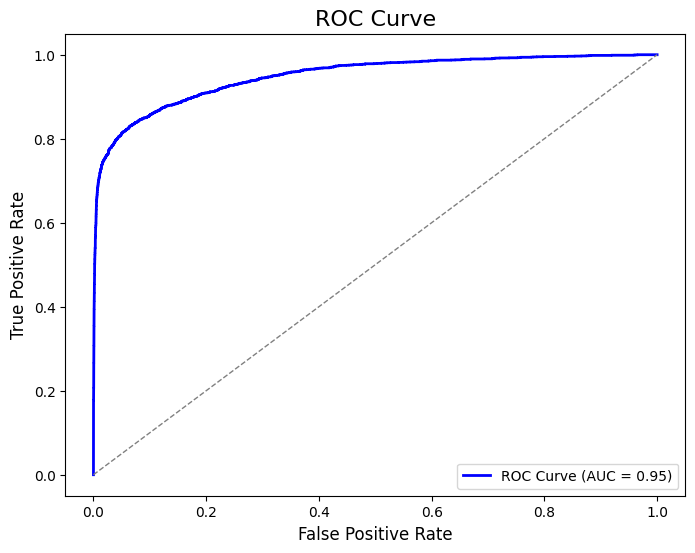

In [194]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right')

plt.show()

## Checking the metrices acrcross different probbility thresholds

In [112]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score


xgb = XGBClassifier(eval_metric='logloss', random_state=30)
xgb.fit(X_train_resampled, y_train_resampled)

probabilities = xgb.predict_proba(X_test)[:, 1]  

def evaluate_threshold(threshold):
    predictions = (probabilities >= threshold).astype(int) 
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities)

    print(f'Threshold: {threshold:.2f} | AUC: {auc:.2f} | F1 Score: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f}')

for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    evaluate_threshold(thresh)


Threshold: 0.30 | AUC: 0.95 | F1 Score: 0.77 | Precision: 0.73 | Recall: 0.81
Threshold: 0.40 | AUC: 0.95 | F1 Score: 0.79 | Precision: 0.81 | Recall: 0.78
Threshold: 0.50 | AUC: 0.95 | F1 Score: 0.80 | Precision: 0.86 | Recall: 0.75
Threshold: 0.60 | AUC: 0.95 | F1 Score: 0.80 | Precision: 0.90 | Recall: 0.72
Threshold: 0.70 | AUC: 0.95 | F1 Score: 0.79 | Precision: 0.92 | Recall: 0.69


### It seems 0.5 is the optimum probability threshold.

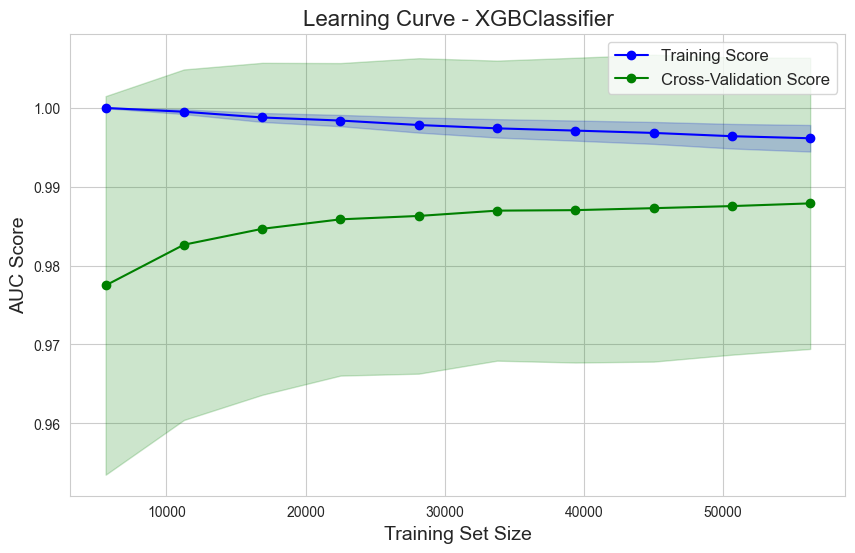

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb,
    X=X_train_resampled,
    y=y_train_resampled,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=30
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve - XGBClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('AUC Score', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.show()


# Blending Model

In [317]:
# Create the Voting Classifier

voting_classifier = VotingClassifier(
    estimators=[
        ('catboost', catboost),
        ('xgboost', xgb),
        ('lightgbm', lightgbm)
    ],
    voting='soft',
    #weights=[0.5, 0.5]  
)

voting_classifier.fit(X_train_resampled_scaled, y_train_resampled)

voting_preds = voting_classifier.predict_proba(X_test_scaled)[:, 1]

voting_auc = roc_auc_score(y_test, voting_preds)

print(f"Voting Classifier AUC Score: {voting_auc:.2f}")

Learning rate set to 0.074091
0:	learn: 0.6368510	total: 7.91ms	remaining: 7.9s
1:	learn: 0.5826107	total: 14.8ms	remaining: 7.36s
2:	learn: 0.5382323	total: 21.8ms	remaining: 7.23s
3:	learn: 0.5061588	total: 28.7ms	remaining: 7.15s
4:	learn: 0.4818828	total: 35.5ms	remaining: 7.05s
5:	learn: 0.4595454	total: 42.6ms	remaining: 7.06s
6:	learn: 0.4374928	total: 49.4ms	remaining: 7.01s
7:	learn: 0.4247823	total: 56.4ms	remaining: 6.99s
8:	learn: 0.4122430	total: 63.2ms	remaining: 6.96s
9:	learn: 0.3998455	total: 70.4ms	remaining: 6.97s
10:	learn: 0.3874955	total: 76.9ms	remaining: 6.91s
11:	learn: 0.3741809	total: 83.9ms	remaining: 6.91s
12:	learn: 0.3665008	total: 90.6ms	remaining: 6.87s
13:	learn: 0.3611487	total: 97.2ms	remaining: 6.84s
14:	learn: 0.3537634	total: 104ms	remaining: 6.84s
15:	learn: 0.3455875	total: 111ms	remaining: 6.86s
16:	learn: 0.3340311	total: 118ms	remaining: 6.81s
17:	learn: 0.3280926	total: 125ms	remaining: 6.79s
18:	learn: 0.3210441	total: 131ms	remaining: 6.78

In [132]:

#catboost_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
#xgboost_model = XGBClassifier(random_seed=42, use_label_encoder=False, eval_metric='logloss')

#catboost.fit(X_train_resampled_scaled, y_train_resampled)
#xgb.fit(X_train_resampled_scaled, y_train_resampled)

catboost_preds = catboost.predict_proba(X_test_scaled)[:, 1]
xgboost_preds = xgb.predict_proba(X_test_scaled)[:, 1]

weights = [0.6, 0.4]
blended_preds = (weights[0] * catboost_preds) + (weights[1] * xgboost_preds)

blended_auc = roc_auc_score(y_test, blended_preds)
print(f"Blended Model AUC Score: {blended_auc:.2f}")


Blended Model AUC Score: 0.95


In [133]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

base_estimators = [
    ('catboost', catboost),
    ('xgboost', xgb)
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5,  
)

stacking_model.fit(X_train_resampled_scaled, y_train_resampled)

stacking_preds = stacking_model.predict_proba(X_test_scaled)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_preds)

print(f"Stacking Model AUC Score: {stacking_auc:.2f}")


Learning rate set to 0.074091
0:	learn: 0.6273788	total: 7.98ms	remaining: 7.97s
1:	learn: 0.5834304	total: 15.5ms	remaining: 7.71s
2:	learn: 0.5458392	total: 23ms	remaining: 7.65s
3:	learn: 0.5125808	total: 30.3ms	remaining: 7.55s
4:	learn: 0.4918187	total: 37.6ms	remaining: 7.49s
5:	learn: 0.4670359	total: 44.9ms	remaining: 7.44s
6:	learn: 0.4511410	total: 52.4ms	remaining: 7.43s
7:	learn: 0.4374397	total: 59.8ms	remaining: 7.42s
8:	learn: 0.4259827	total: 67.3ms	remaining: 7.41s
9:	learn: 0.4158069	total: 75.3ms	remaining: 7.46s
10:	learn: 0.4034424	total: 83.3ms	remaining: 7.49s
11:	learn: 0.3924667	total: 91ms	remaining: 7.49s
12:	learn: 0.3847057	total: 98.4ms	remaining: 7.47s
13:	learn: 0.3763847	total: 106ms	remaining: 7.46s
14:	learn: 0.3711216	total: 113ms	remaining: 7.41s
15:	learn: 0.3670657	total: 120ms	remaining: 7.39s
16:	learn: 0.3623157	total: 128ms	remaining: 7.38s
17:	learn: 0.3585404	total: 135ms	remaining: 7.34s
18:	learn: 0.3553490	total: 143ms	remaining: 7.36s
19

# Prediction on Kaggle Test Data

In [318]:
# 1. Loan-to-Income Ratio
test_df['loan_to_income_ratio'] = test_df['loan_amnt'] / test_df['person_income']

# 2. Employment Stability Features
# Bin employment length into categories (using the same bins and labels)
bins = [0, 1, 5, 10, float('inf')]
labels = ['0-1 years', '2-5 years', '6-10 years', '11+ years']
test_df['emp_length_bin'] = pd.cut(test_df['person_emp_length'], bins=bins, labels=labels, right=False)

# Income Growth Potential: If high income but short employment length indicates growth potential
test_df['income_growth_potential'] = (test_df['person_income'] > test_df['person_income'].median()) & (test_df['person_emp_length'] < 2)

# 3. Credit Age to Employment Length Ratio
test_df['credit_age_to_emp_length_ratio'] = test_df['cb_person_cred_hist_length'] / (test_df['person_emp_length'] + 1)

# 4. Loan Percent Income High: Binary feature indicating if loan percentage of income exceeds 30%
test_df['loan_percent_income_high'] = test_df['loan_percent_income'] > 0.30

# 5. Loan Amount Bins: Grouping loans into 'small', 'medium', and 'large' bins
loan_bins = [0, 5000, 10000, float('inf')]
loan_labels = ['small', 'medium', 'large']
test_df['loan_amnt_bin'] = pd.cut(test_df['loan_amnt'], bins=loan_bins, labels=loan_labels, right=False)

# Mapping the features as done for the training set
test_df['income_growth_potential'] = test_df['income_growth_potential'].map({True: 1, False: 0})
test_df['loan_amnt_bin'] = test_df['loan_amnt_bin'].map({'small': 0, 'medium': 1, 'large': 2}).astype(int)
test_df['loan_percent_income_high'] = test_df['loan_percent_income_high'].map({True: 1, False: 0})
test_df['emp_length_bin'] = test_df['emp_length_bin'].map({'0-1 years': 0, '2-5 years': 1, '6-10 years': 2, '11+ years': 3}).astype(int)


In [319]:
test_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio,emp_length_bin,income_growth_potential,credit_age_to_emp_length_ratio,loan_percent_income_high,loan_amnt_bin
0,58645,23,69000,3,3.0,2,5,25000,15.76,0.36,0,2,0.362319,1,0,0.500000,1,2
1,58646,26,96000,0,6.0,4,2,10000,12.68,0.10,1,4,0.104167,2,0,0.571429,0,2
2,58647,26,30000,3,5.0,5,4,4000,17.19,0.13,1,2,0.133333,2,0,0.333333,0,0
3,58648,33,50000,3,4.0,0,0,7000,8.90,0.14,0,7,0.140000,1,0,1.400000,0,1
4,58649,26,102000,0,8.0,2,3,15000,16.32,0.15,1,4,0.147059,2,0,0.444444,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,0,2.0,0,1,3000,10.37,0.10,0,4,0.096154,1,0,1.333333,0,0
39094,97739,22,48000,0,6.0,1,0,7000,6.03,0.15,0,3,0.145833,2,0,0.428571,0,1
39095,97740,51,60000,0,0.0,4,0,15000,7.51,0.25,0,25,0.250000,0,1,25.000000,0,2
39096,97741,22,36000,0,4.0,4,3,14000,15.62,0.39,1,4,0.388889,1,0,0.800000,1,2


In [320]:
test_ids = test_df['id']
test_df_scaled = test_df.drop(columns=['id'])

test_df_scaled = pd.DataFrame(scaler.transform(test_df_scaled), columns=test_df_scaled.columns)

test_df_scaled['id'] = test_ids.values

test_df_scaled

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio,emp_length_bin,income_growth_potential,credit_age_to_emp_length_ratio,loan_percent_income_high,loan_amnt_bin,id
0,-0.747889,0.268061,0.805130,-0.368331,-0.179033,3.199727,2.382018,1.272522,1.428690,-0.408729,-0.935530,1.424825,-0.294611,-0.256213,-0.605659,1.970985,0.945665,58645
1,-0.222927,0.955771,-1.393436,0.451116,1.054946,0.562064,-0.005966,0.296519,-0.823408,2.446609,-0.406406,-0.786592,0.915829,-0.256213,-0.575615,-0.507360,0.945665,58646
2,-0.222927,-0.725298,0.805130,0.177967,1.671935,2.320506,-0.961160,1.725667,-0.563550,2.446609,-0.935530,-0.536741,0.915829,-0.256213,-0.675762,-0.507360,-1.649652,58647
3,1.001984,-0.215883,0.805130,-0.095182,-1.413011,-1.196378,-0.483563,-0.901304,-0.476931,-0.408729,0.387281,-0.479632,-0.294611,-0.256213,-0.227102,-0.507360,-0.351993,58648
4,-0.222927,1.108595,-1.393436,0.997414,-0.179033,1.441285,0.790028,1.449978,-0.390312,2.446609,-0.406406,-0.419164,0.915829,-0.256213,-0.629027,-0.507360,0.945665,58649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,-0.922876,-0.694733,-1.393436,-0.641480,-1.413011,-0.317157,-1.120359,-0.435484,-0.823408,-0.408729,-0.406406,-0.855233,-0.294611,-0.256213,-0.255143,-0.507360,-1.649652,97738
39094,-0.922876,-0.266825,-1.393436,0.451116,-0.796022,-1.196378,-0.483563,-1.810762,-0.390312,-0.408729,-0.670968,-0.429662,0.915829,-0.256213,-0.635703,-0.507360,-0.351993,97739
39095,4.151756,0.038824,-1.393436,-1.187778,1.054946,-1.196378,0.790028,-1.341773,0.475879,-0.408729,5.149402,0.462664,-1.505051,3.903001,9.699515,-0.507360,0.945665,97740
39096,-0.922876,-0.572474,-1.393436,-0.095182,1.054946,1.441285,0.630829,1.228159,1.688547,2.446609,-0.406406,1.652433,-0.294611,-0.256213,-0.479473,1.970985,0.945665,97741


In [323]:
import pandas as pd

X_test_features = test_df_scaled.drop(columns=['id'], errors='ignore')

probabilities = voting_classifier.predict_proba(X_test_features)[:, 1]

predictions_df = pd.DataFrame({
    'id': test_df_scaled['id'].values,  
    'loan_status': probabilities
})

predictions_df.to_csv('xgb_lgb_cat_voting_classifier_predictions.csv', index=False)

predictions_df.head()


,id,loan_status
0,58645,0.997707
1,58646,0.041596
2,58647,0.369467
3,58648,0.027195
4,58649,0.110724


In [322]:
voting_classifier

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x34977cc90>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gr...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=30, ...)),
                             ('lightgbm', LGBMClassifier(random_state=30))],
                 voting='soft')

In [136]:
X_test_features = test_df_scaled.drop(columns=['id'], errors='ignore')


# Make predictions on the test set
catboost_preds = catboost.predict_proba(X_test_features)[:, 1]
xgboost_preds = xgb.predict_proba(X_test_features)[:, 1]

# Define blending weights (these can be tuned)
weights = [0.6, 0.4]  # Example weights
blended_preds = (weights[0] * catboost_preds) + (weights[1] * xgboost_preds)

# Assuming y_test is available for the test set labels
# Calculate the AUC score for blended predictions
# Note: If y_test is not available for the test set, you may want to skip this step.
# For demonstration purposes, I will assume you have y_test defined.
#blended_auc = roc_auc_score(y_test, blended_preds)  # Only if y_test is available for evaluation
#print(f"Blended Model AUC Score: {blended_auc:.2f}")

# Prepare the final predictions DataFrame for submission
predictions_df = pd.DataFrame({
    'id': test_df['id'].values,  # Make sure to use the original test DataFrame
    'loan_status': blended_preds
})

predictions_df.to_csv('originalFeatures_weight_blended_classifier_predictions.csv', index=False)

predictions_df.head()

,id,loan_status
0,58645,0.998960
1,58646,0.028329
2,58647,0.325026
3,58648,0.017890
4,58649,0.077119


In [77]:
predictions_df

NameError: name 'predictions_df' is not defined